In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.environ['MUJOCO_PY_MJKEY_PATH'] = '../mjpro131/bin/mjkey.txt'
os.environ['MUJOCO_PY_MJPRO_PATH'] = '../mjpro131'
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import os
import run_expert
import pdb

In [3]:
def get_expert_rollouts(task, num_rollouts):
    policy_fn = load_policy.load_policy('experts/{}.pkl'.format(task))
    env = gym.make(task)
    max_steps = env.spec.timestep_limit
    returns = []
    observations = []
    actions = []
    for i in range(num_rollouts):
        if i % 10 == 0:
            print 'Expert rollout number {}'.format(i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(obs[None,:])[0]
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if steps >= max_steps:
                break
        returns.append(totalr)
    
    return returns, observations, actions

In [4]:
def behavioral_cloning(task):
    with tf.Session() as sess:
        # get expert rollouts
        env = gym.make(task)
        max_steps = env.spec.timestep_limit
        print 'Max steps per rollout is {}'.format(max_steps)
        num_rollouts = 100
        num_epochs = 200

        returns, observations, actions = get_expert_rollouts(task, num_rollouts)
        mean_obs = np.average(observations, axis=0)
        std_obs = np.std(observations, axis=0)+1e-6

        # set up network
        d_obs = env.observation_space.shape[0]
        d_actions = env.action_space.shape[0]
        sy_obs = tf.placeholder(tf.float32, [None,d_obs])
        sy_actions = tf.placeholder(tf.float32, [None,d_actions])

        w1 = tf.Variable(tf.truncated_normal([d_obs,64],stddev=1.0/d_obs**0.5))
        b1 = tf.Variable(tf.zeros([64]))
        h1 = tf.nn.relu(tf.matmul(sy_obs,w1)+b1)
        
        w2 = tf.Variable(tf.truncated_normal([64,64],stddev=1.0/8))
        b2 = tf.Variable(tf.zeros([64]))
        h2 = tf.nn.relu(tf.matmul(h1,w2)+b2)
        
        w3 = tf.Variable(tf.truncated_normal([64,d_actions],stddev=1.0/8))
        b3 = tf.Variable(tf.zeros([d_actions]))
        pred_actions = tf.matmul(h2,w3)+b3

        beta = 0.0001
        reg = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)
        loss = tf.reduce_mean(tf.square(sy_actions-pred_actions))
        loss = tf.reduce_mean(loss + beta*reg)
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
        # train network on expert rollouts
        train_losses = []
        init = tf.global_variables_initializer()
        sess.run(init)
        batch_size = 1000
        for i in range(num_epochs):
            if i % 10 == 0:
                print 'Epoch number {}'.format(i)
            for j in range(len(observations)/batch_size):
                obs = (observations[batch_size*j:batch_size*(j+1)]-mean_obs)/std_obs
                act = actions[batch_size*j:batch_size*(j+1)]
                train_loss, _ = sess.run([loss,train_step], feed_dict={sy_obs: obs, sy_actions: act})
                train_losses.append(train_loss)

        # test model
        test_returns = []
        test_observations = []
        test_actions = []
        for i in range(num_rollouts/10):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                obs = (obs[np.newaxis]-mean_obs)/std_obs
                action = sess.run(pred_actions, feed_dict={sy_obs: obs})
                test_observations.append(obs)
                test_actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                env.render()
                if steps >= max_steps:
                    break
            test_returns.append(totalr)
        return train_losses, returns, test_returns

In [5]:
def query_expert(task, observations):
    policy_fn = load_policy.load_policy('experts/{}.pkl'.format(task))
    actions = []
    for i in range(len(observations)):
        action = policy_fn(observations[i][None,:])[0]
        actions.append(action)
    return actions

In [12]:
def dagger(task):
    with tf.Session() as sess:
        # get expert rollouts
        env = gym.make(task)
        max_steps = env.spec.timestep_limit
        print 'Max steps per rollout is {}'.format(max_steps)
        num_rollouts = 100

        returns, observations, actions = get_expert_rollouts(task, num_rollouts)
        mean_obs = np.average(observations, axis=0)
        std_obs = np.std(observations, axis=0)+1e-6

        # set up network
        d_obs = env.observation_space.shape[0]
        d_actions = env.action_space.shape[0]
        sy_obs = tf.placeholder(tf.float32, [None,d_obs])
        sy_actions = tf.placeholder(tf.float32, [None,d_actions])

        w1 = tf.Variable(tf.truncated_normal([d_obs,64],stddev=1.0/d_obs**0.5))
        b1 = tf.Variable(tf.zeros([64]))
        h1 = tf.nn.relu(tf.matmul(sy_obs,w1)+b1)
        
        w2 = tf.Variable(tf.truncated_normal([64,64],stddev=1.0/8))
        b2 = tf.Variable(tf.zeros([64]))
        h2 = tf.nn.relu(tf.matmul(h1,w2)+b2)
        
        w3 = tf.Variable(tf.truncated_normal([64,d_actions],stddev=1.0/8))
        b3 = tf.Variable(tf.zeros([d_actions]))
        pred_actions = tf.matmul(h2,w3)+b3

        beta = 0.0001
        reg = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)
        loss = tf.reduce_mean(tf.square(sy_actions-pred_actions))
        loss = tf.reduce_mean(loss + beta*reg)
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
        train_losses = []
        init = tf.global_variables_initializer()
        sess.run(init)
        batch_size = 1000
        num_loops = 10
        
        for l in range(num_loops):
            if l % 10 == 0:
                print 'Loop number {}'.format(l)
            # train network
            for i in range(10):
                for j in range(len(observations)/batch_size):
                    obs = (observations[batch_size*j:batch_size*(j+1)]-mean_obs)/std_obs
                    act = actions[batch_size*j:batch_size*(j+1)]
                    train_loss, _ = sess.run([loss,train_step], feed_dict={sy_obs: obs, sy_actions: act})
                    train_losses.append(train_loss)
            val_returns = []
            val_observations = []
            val_actions = []
            # generate rollout with policy
            for i in range(num_rollouts/10):
                obs = env.reset()
                done = False
                totalr = 0.
                steps = 0
                while not done:
                    val_observations.append(obs)
                    obs = (obs[None,:]-mean_obs)/std_obs
                    action = sess.run(pred_actions, feed_dict={sy_obs: obs})
                    val_actions.append(action)
                    obs, r, done, _ = env.step(action)
                    totalr += r
                    steps += 1
                    if steps >= max_steps:
                        break
                val_returns.append(totalr)
            observations = val_observations
            # label
            actions = query_expert(task, observations)

        # test model
        test_returns = []
        test_observations = []
        test_actions = []
        for i in range(num_rollouts/10):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                obs = (obs[None,:]-mean_obs)/std_obs
                action = sess.run(pred_actions, feed_dict={sy_obs: obs})
                test_observations.append(obs)
                test_actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if steps >= max_steps:
                    break
            test_returns.append(totalr)
        return train_losses, returns, test_returns

In [40]:
train_losses, returns, test_returns = behavioral_cloning('Hopper-v1')

INFO:gym.envs.registration:Making new env: Hopper-v1
[2017-05-26 01:27:43,502] Making new env: Hopper-v1
INFO:gym.envs.registration:Making new env: Hopper-v1
[2017-05-26 01:27:43,542] Making new env: Hopper-v1


Max steps per rollout is 1000
Expert rollout number 0
Expert rollout number 10
Expert rollout number 20
Expert rollout number 30
Expert rollout number 40
Expert rollout number 50
Expert rollout number 60
Expert rollout number 70
Expert rollout number 80
Expert rollout number 90
Epoch number 0
Epoch number 10
Epoch number 20
Epoch number 30
Epoch number 40
Epoch number 50
Epoch number 60
Epoch number 70


KeyboardInterrupt: 

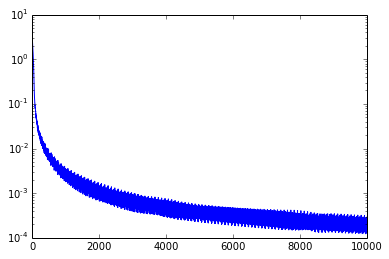

In [26]:
plt.plot(range(10000),train_losses)
plt.yscale('log')
plt.show()

In [27]:
np.average(returns)

3777.7417064410752

In [28]:
np.average(test_returns)

3779.6032157000509

In [70]:
r_train_losses, r_returns, r_test_returns = behavioral_cloning('Reacher-v1')

INFO:gym.envs.registration:Making new env: Reacher-v1
[2017-05-26 02:14:36,465] Making new env: Reacher-v1
INFO:gym.envs.registration:Making new env: Reacher-v1
[2017-05-26 02:14:36,492] Making new env: Reacher-v1


Max steps per rollout is 50
Expert rollout number 0
Expert rollout number 10
Expert rollout number 20
Expert rollout number 30
Expert rollout number 40
Expert rollout number 50
Expert rollout number 60
Expert rollout number 70
Expert rollout number 80
Expert rollout number 90
Epoch number 0
Epoch number 10
Epoch number 20
Epoch number 30
Epoch number 40
Epoch number 50
Epoch number 60
Epoch number 70
Epoch number 80
Epoch number 90
Epoch number 100
Epoch number 110
Epoch number 120
Epoch number 130
Epoch number 140
Epoch number 150
Epoch number 160
Epoch number 170
Epoch number 180
Epoch number 190


In [71]:
np.std(r_returns)

1.5273179039476832

In [72]:
np.average(r_test_returns)

-3.4020531079797598

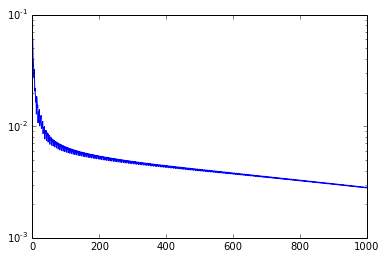

In [73]:
plt.plot(range(len(r_train_losses)),r_train_losses)
plt.yscale('log')
plt.show()

In [79]:
h_train_losses, h_returns, h_test_returns = behavioral_cloning('Humanoid-v1')

INFO:gym.envs.registration:Making new env: Humanoid-v1
[2017-05-26 02:27:54,995] Making new env: Humanoid-v1
INFO:gym.envs.registration:Making new env: Humanoid-v1
[2017-05-26 02:27:55,036] Making new env: Humanoid-v1


Max steps per rollout is 1000
Expert rollout number 0
Expert rollout number 10
Expert rollout number 20
Expert rollout number 30
Expert rollout number 40
Expert rollout number 50
Expert rollout number 60
Expert rollout number 70
Expert rollout number 80
Expert rollout number 90
Epoch number 0
Epoch number 10
Epoch number 20
Epoch number 30
Epoch number 40
Epoch number 50
Epoch number 60
Epoch number 70
Epoch number 80
Epoch number 90
Epoch number 100
Epoch number 110
Epoch number 120
Epoch number 130
Epoch number 140
Epoch number 150
Epoch number 160
Epoch number 170
Epoch number 180
Epoch number 190


In [75]:
np.average(h_returns)

10311.402561397663

In [76]:
np.average(h_test_returns)

10393.615119916698

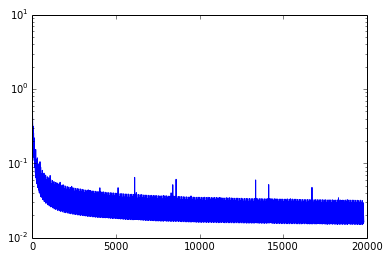

In [77]:
plt.plot(range(len(h_train_losses)),h_train_losses)
plt.yscale('log')
plt.show()

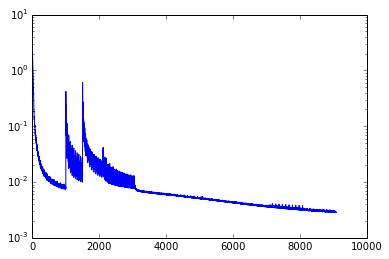

In [13]:
plt.plot(range(len(d_train_losses)),d_train_losses)
plt.yscale('log')
plt.show()

In [14]:
d_train_losses, d_returns, d_test_returns = dagger('Hopper-v1')

INFO:gym.envs.registration:Making new env: Hopper-v1
[2017-05-26 03:21:03,465] Making new env: Hopper-v1
INFO:gym.envs.registration:Making new env: Hopper-v1
[2017-05-26 03:21:03,501] Making new env: Hopper-v1


Max steps per rollout is 1000
Expert rollout number 0
Expert rollout number 10
Expert rollout number 20
Expert rollout number 30
Expert rollout number 40
Expert rollout number 50
Expert rollout number 60
Expert rollout number 70
Expert rollout number 80
Expert rollout number 90
Loop number 0


In [15]:
np.average(d_test_returns)

3782.6147345435224

In [16]:
np.average(d_returns)

3779.0729742877866